# 2D U-Net

In this notebook, we use a 2D U-Net to train a segmentation model that can segment nuclei from images of cells.

[U-Net](https://en.wikipedia.org/wiki/U-Net) is a fully-convolutional network created with an encoder-decoder topology. [Ronnenberger et al.](https://arxiv.org/abs/1505.04597) created the topology in 2015 for use in biomedical imaging.

![unet](https://upload.wikimedia.org/wikipedia/commons/2/2b/Example_architecture_of_U-Net_for_producing_k_256-by-256_image_masks_for_a_256-by-256_RGB_image.png)

## Download Broad Dataset
### Broad Bioimage Benchmark Collection
#### Kaggle 2018 Data Science Bowl
https://bbbc.broadinstitute.org/BBBC038

This image data set contains a large number of segmented nuclei images and was created for the Kaggle 2018 Data Science Bowl sponsored by Booz Allen Hamilton with cash prizes. The image set was a testing ground for the application of novel and cutting edge approaches in computer vision and machine learning to the segmentation of the nuclei belonging to cells from a breadth of biological contexts.

Images
These images form a diverse collection of biological images collectively containing tens of thousands of nuclei. The variety within the data set reflects the type of images collected by research biologists at universities, bio-techs, and hospitals. The nuclei in the images are derived from a range of organisms including humans, mice, and flies. In addition, nuclei have been treated and imaged in a variety of conditions including fluorescent and histology stains, several magnifications, and varying quality of illumination. Finally, nuclei appear in different contexts and states including cultured mono-layers, tissues, and embryos, and cell division, genotoxic stress, and differentiation. The dataset is designed to challenge an algorithm's ability to generalize across these variations.

In [1]:
import tensorflow as tf
import os

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

%matplotlib inline

In [2]:
# Download the Broad dataset
# Could take a few minutes depending on your internet connection so be patient
zipfilename = "stage1_train.zip"
broad_url = "https://data.broadinstitute.org/bbbc/BBBC038/" + zipfilename
local_dataset_directory = "./broad_data"

try:
    broad = tf.keras.utils.get_file(
        fname=zipfilename,
        origin=broad_url,
        cache_subdir=local_dataset_directory,
        cache_dir=".",
        extract=True,
    )

    print(f"The dataset was extracted to {broad}")

except Exception as inst:

    print("Error in downloading the dataset.")
    print(inst)

The dataset was extracted to ././broad_data/stage1_train.zip


## Create a TensorFlow tf.data Dataloader

Let's try to use some tf.data methods to glob file patterns

In [3]:
# Gets all filename matching pattern
ds = tf.data.Dataset.list_files(
    os.path.join(local_dataset_directory, "*/images/*.png")
)

In [4]:
for filename in ds.shuffle(50).take(10):
    print(filename)

tf.Tensor(b'./broad_data/08151b19806eebd58e5acec7e138dbfbb1761f41a1ab9620466584ecc7d5fada/images/08151b19806eebd58e5acec7e138dbfbb1761f41a1ab9620466584ecc7d5fada.png', shape=(), dtype=string)
tf.Tensor(b'./broad_data/b4d902d42c93dea77b541456f8d905f35eeb24fc3a5b0b15b5678d78e0aabe0c/images/b4d902d42c93dea77b541456f8d905f35eeb24fc3a5b0b15b5678d78e0aabe0c.png', shape=(), dtype=string)
tf.Tensor(b'./broad_data/d751ccb64fa767a65a966061218438bd1860695d96bbef11fdb2f0d3b8dedba8/images/d751ccb64fa767a65a966061218438bd1860695d96bbef11fdb2f0d3b8dedba8.png', shape=(), dtype=string)
tf.Tensor(b'./broad_data/86f9087eb1d0875ffb1a28cca7645b14d6c66f995c7d96aa13969d2f8115d533/images/86f9087eb1d0875ffb1a28cca7645b14d6c66f995c7d96aa13969d2f8115d533.png', shape=(), dtype=string)
tf.Tensor(b'./broad_data/9774c82396327929fea05e40ae153cabf0107178b2ae3e40a5709b409793887e/images/9774c82396327929fea05e40ae153cabf0107178b2ae3e40a5709b409793887e.png', shape=(), dtype=string)
tf.Tensor(b'./broad_data/0d3640c1f1b80f2

In [5]:
def process_image(filename):

    img_io = tf.io.read_file(filename)
    img = tf.io.decode_png(img_io, channels=3)

    return img

In [6]:
def process_mask(filename):

    mask_io = tf.io.read_file(filename)
    mask = tf.io.decode_png(mask_io, channels=1)  # Grayscale

    return mask

In [7]:
def process_path(img_filename):

    # Load the raw image from the file as a string
    image = process_image(img_filename)

    # RegEx to replace /images/*.png with /masks
    mask_directory = tf.strings.regex_replace(
        img_filename, "images/(.+).png", "masks/*.png"
    )
    mask_filenames = tf.io.matching_files(mask_directory)

    mask = process_mask(img_filename)

    """
    TODO: Can't figure out how to create the tf.zeros with the image shape
    """
    for filename in mask_filenames:
        mask = process_mask(filename)
        break

    for filename in mask_filenames:
        mask += process_mask(filename)

    image = tf.image.resize(image / 255, [256,256])
    mask = tf.image.resize(mask / 255, [256,256])
    
    return image, mask

In [8]:
ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [26]:
train_split = 0.80
val_split = 0.50

train_length = int(train_split * len(ds))
train_ds = ds.take(train_length)

remain_ds = ds.skip(train_length)
val_length = int(val_split * len(remain_ds))
val_ds = remain_ds.take(val_length)
test_ds = remain_ds.skip(val_length)

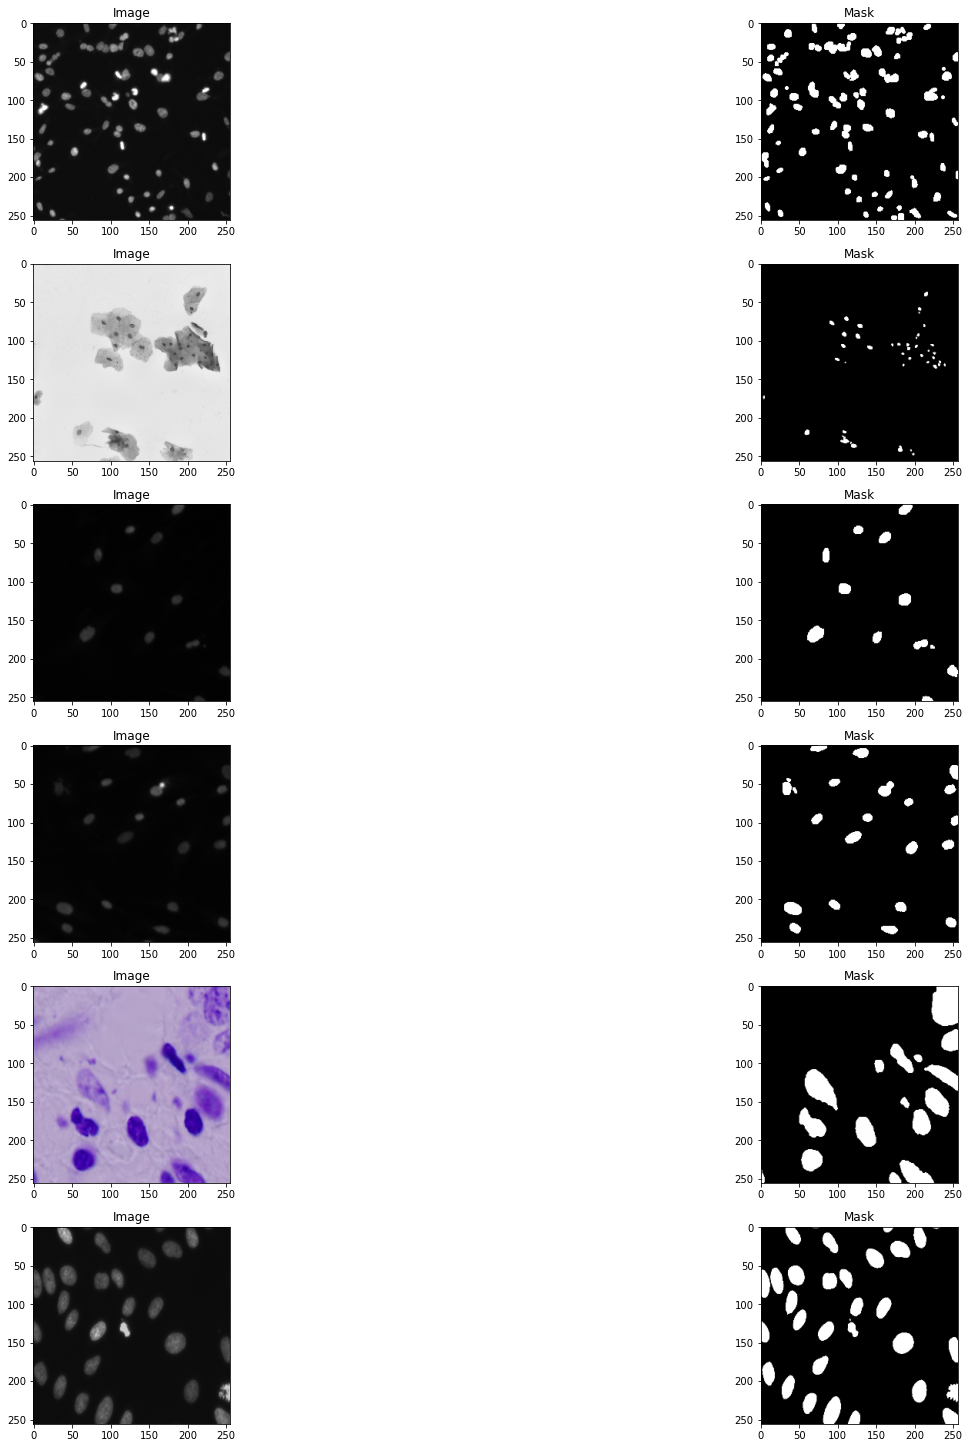

In [28]:
N = 6
idx = 0

fig = plt.figure(figsize=(20, 20), constrained_layout=True)
gs = GridSpec(N, 2, figure=fig)
axs = []

for image, mask in train_ds.shuffle(30).take(N):

    axs.append(fig.add_subplot(gs[idx]))
    axs[-1].imshow(image.numpy())
    # print("Image shape: ", image.numpy().shape)
    plt.title("Image")

    axs.append(fig.add_subplot(gs[idx + 1]))
    axs[-1].imshow(mask.numpy(), cmap="gray")
    plt.title("Mask")

    idx += 2

## Define U-Net 

Define the 2D U-Net model
* Define encoder block
* Define decoder block
* Stack and connect blocks

In [11]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.5, max_pooling=True):

    conv1 = tf.keras.layers.Conv2D(
        filters=n_filters, kernel_size=(3, 3), activation="relu", padding="same"
    )(inputs)
    conv2 = tf.keras.layers.Conv2D(
        filters=n_filters, kernel_size=(3, 3), activation="relu", padding="same"
    )(conv1)

    bn1 = tf.keras.layers.BatchNormalization()(conv2)

    if dropout_prob > 0:
        bn1 = tf.keras.layers.Dropout(dropout_prob)(bn1)

    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(bn1)
    else:
        next_layer = bn1

    # skip connection (without max pooling) 
    skip_connection = bn1

    return next_layer, skip_connection

In [12]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):

    # Start with a transpose convolution layer to first increase the size of the image
    up = tf.keras.layers.Conv2DTranspose(
        filters=n_filters, kernel_size=(3, 3), strides=(2, 2), padding="same"
    )(prev_layer_input)

    merge = tf.keras.layers.concatenate([up, skip_layer_input], axis=-1)

    conv1 = tf.keras.layers.Conv2D(
        filters=n_filters, kernel_size=(3, 3), activation="relu", padding="same"
    )(merge)
    conv2 = tf.keras.layers.Conv2D(
        filters=n_filters, kernel_size=(3, 3), activation="relu", padding="same"
    )(conv1)

    return conv2

## Define the 2D U-Net model

Here we use the encoder/decoder blocks and hook them together to form U-Net.

In [13]:
def UNet2D(input_size=(None, None, 3), n_filters=32, n_classes=1):
    """
    Combine both encoder and decoder blocks
    Return the model as output
    """

    inputs = tf.keras.layers.Input(input_size, name="image")

    # Encoder section
    cblock1 = EncoderMiniBlock(inputs, n_filters, dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(
        cblock1[0], n_filters * 2, dropout_prob=0, max_pooling=True
    )
    cblock3 = EncoderMiniBlock(
        cblock2[0], n_filters * 4, dropout_prob=0, max_pooling=True
    )
    cblock4 = EncoderMiniBlock(
        cblock3[0], n_filters * 8, dropout_prob=0.3, max_pooling=True
    )
    cblock5 = EncoderMiniBlock(
        cblock4[0], n_filters * 16, dropout_prob=0.3, max_pooling=False
    )

    # Decoder section
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1], n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1], n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1], n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1], n_filters)

    conv9 = tf.keras.layers.Conv2D(
        filters=n_filters, kernel_size=(3, 3), activation="relu", padding="same"
    )(ublock9)


    if n_classes == 1:
        activation="sigmoid"
    else:
        activation="softmax"
        
    prediction = tf.keras.layers.Conv2D(
        filters=n_classes, kernel_size=(1, 1), padding="same", activation=activation, name="prediction"
    )(conv9)

    # Define the model
    model = tf.keras.models.Model(inputs=[inputs], outputs=[prediction])

    return model

## Create the 2D U-Net model

In [14]:
n_classes = 1
unet_model = UNet2D(n_filters=8, n_classes=n_classes)

In [15]:
unet_model.summary(line_length=120)

Model: "model"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 image (InputLayer)                    [(None, None, None, 3)]    0             []                                      
                                                                                                                        
 conv2d (Conv2D)                       (None, None, None, 8)      224           ['image[0][0]']                         
                                                                                                                        
 conv2d_1 (Conv2D)                     (None, None, None, 8)      584           ['conv2d[0][0]']                        
                                                                                                                        
 batch_normalizat

 conv2d_13 (Conv2D)                    (None, None, None, 32)     9248          ['conv2d_12[0][0]']                     
                                                                                                                        
 conv2d_transpose_2 (Conv2DTranspose)  (None, None, None, 16)     4624          ['conv2d_13[0][0]']                     
                                                                                                                        
 concatenate_2 (Concatenate)           (None, None, None, 32)     0             ['conv2d_transpose_2[0][0]',            
                                                                                 'batch_normalization_1[0][0]']         
                                                                                                                        
 conv2d_14 (Conv2D)                    (None, None, None, 16)     4624          ['concatenate_2[0][0]']                 
                                

## We can display the model with Netron

## Wow! A custom metric

The Dice coefficient is often used for segmentation tasks. Dice is the amount of overlap between the mask and the prediction. It is the same as F1.

In [16]:
def dice_coef(target, prediction, axis=(1, 2), smooth=0.01):
    """
    Sorenson Dice
    \frac{  2 \times \left | T \right | \cap \left | P \right |}{ \left | T \right | +  \left | P \right |  }
    where T is ground truth mask and P is the prediction mask
    """
    prediction = tf.math.round(prediction)  # Round to 0 or 1

    intersection = tf.reduce_sum(target * prediction, axis=axis)
    union = tf.reduce_sum(target + prediction, axis=axis)
    numerator = tf.constant(2.) * intersection + smooth
    denominator = union + smooth
    coef = numerator / denominator

    return tf.reduce_mean(coef)

## Compile the U-Net model

In [17]:
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="binary_crossentropy" if n_classes==1 else "categorical_crossentropy",
    metrics=["accuracy", dice_coef],
)

## Specify the batch sizes

In [18]:
train_ds = train_ds.batch(16).prefetch(4)
val_ds = val_ds.batch(8).prefetch(4)
test_ds = test_ds.batch(1)

## Callbacks
### TensorBoard and Model Checkpoints

In [19]:
model_path = "unet_2d_model"
tensorboard_path = "logs"
callbacks = [tf.keras.callbacks.ModelCheckpoint(model_path, verbose=1, save_best_only=True),
            tf.keras.callbacks.TensorBoard(tensorboard_path)]

## Train the model

In [20]:
unet_model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=callbacks)

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 0.3302 - accuracy: 0.8543 - dice_coef: 5.5481e-04
Epoch 1: val_loss improved from inf to 0.42215, saving model to unet_2d_model
INFO:tensorflow:Assets written to: unet_2d_model/assets
34/34 [==============================] - 14s 318ms/step - loss: 0.3302 - accuracy: 0.8543 - dice_coef: 5.5481e-04 - val_loss: 0.4222 - val_accuracy: 0.8566 - val_dice_coef: 2.9129e-06
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.2222 - accuracy: 0.8544 - dice_coef: 4.2647e-04
Epoch 2: val_loss did not improve from 0.42215
34/34 [==============================] - 7s 194ms/step - loss: 0.2222 - accuracy: 0.8544 - dice_coef: 4.2647e-04 - val_loss: 0.4470 - val_accuracy: 0.8698 - val_dice_coef: 3.4747e-06
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.1835 - accuracy: 0.8896 - dice_coef: 0.3952
Epoch 3: val_loss did not improve from 0.42215
34/34 [==============================] - 6s 181ms/step 

In [21]:
%load_ext tensorboard

%tensorboard --logdir logs

## Reload the best saved model

In [22]:
# Reload the best model
unet_model = tf.keras.models.load_model(model_path, compile=False)

## How did the model perform?

Let's take a few of the hold-out test data to evaluate the model performance.

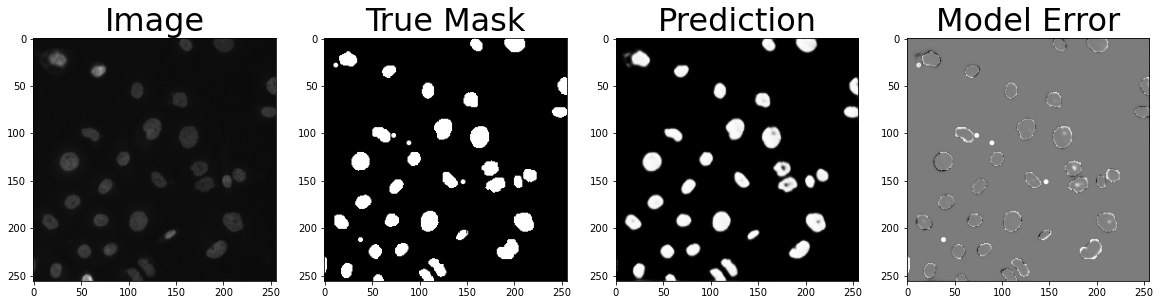

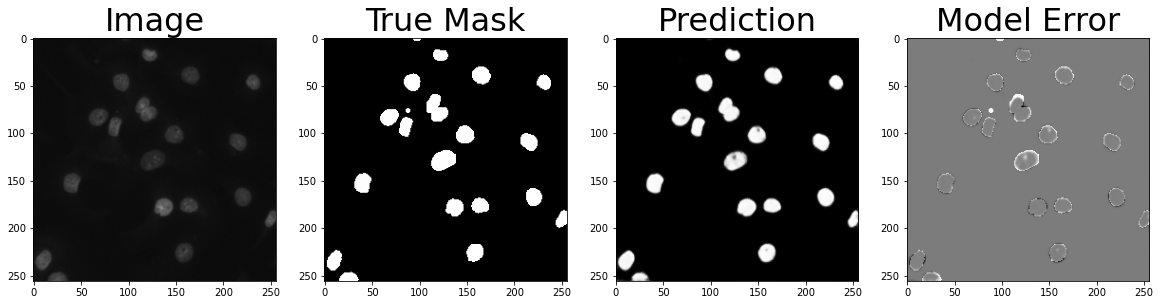

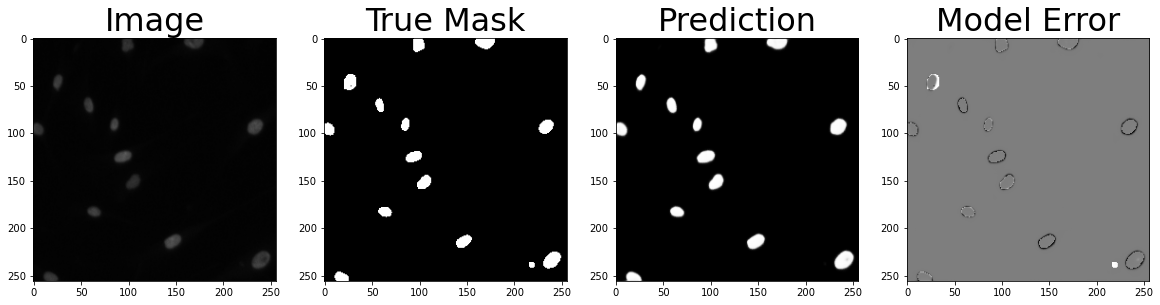

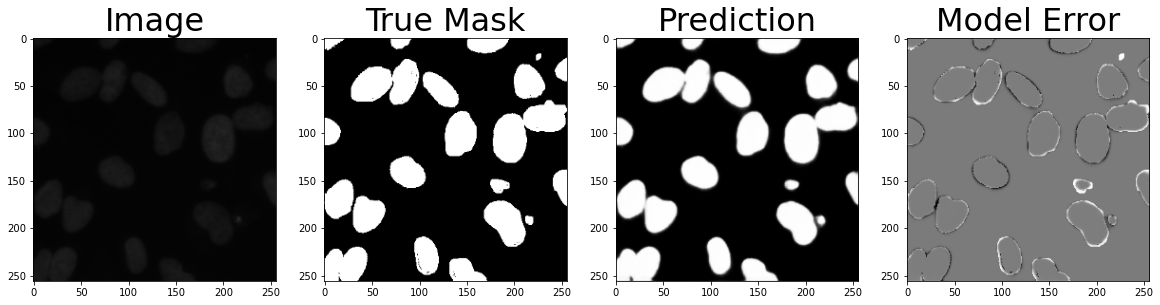

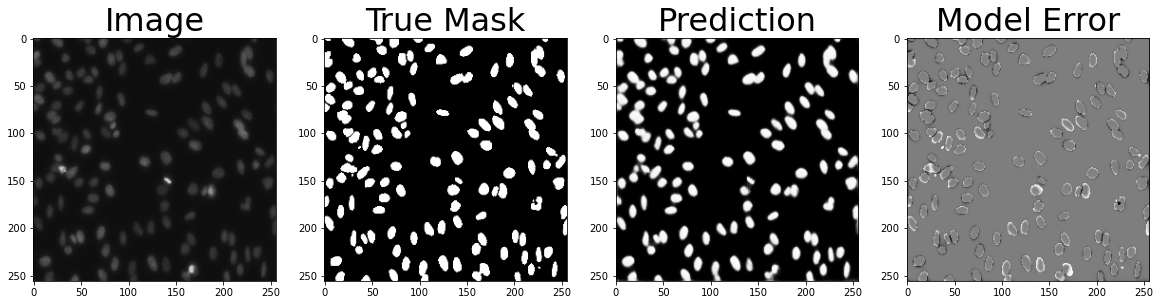

In [23]:
for img, msk in test_ds.take(5):
    
    pred = unet_model.predict(img)
    
    plt.figure(figsize=(20,20))

    plt.subplot(1,4,1)
    plt.imshow(img.numpy()[0])
    plt.title("Image", fontsize=32)

    plt.subplot(1,4,2)
    plt.imshow(msk.numpy()[0], cmap="gray")
    plt.title("True Mask", fontsize=32)

    plt.subplot(1,4,3)
    plt.imshow(pred[0], cmap="gray")
    plt.title("Prediction", fontsize=32)

    plt.subplot(1,4,4)
    plt.imshow(msk.numpy()[0] - pred[0], cmap="gray")
    plt.title("Model Error", fontsize=32)

    plt.show()